# TopoVelo Example Notebook
This notebook provides example code snippets of using TopoVelo, explains how to tune various hyperparameters and introduces more advanced details of the model.

## Step 0: load all necessary modules
First, we assume that spatial transcriptomic data have already been converted to a hdf5-like file with an extension of ".h5ad" or ".loom". We can use [anndata](https://anndata.readthedocs.io/en/latest/), [scanpy](https://scanpy.readthedocs.io/en/stable/) or [scVelo](https://scvelo.readthedocs.io/en/stable/) to load data.<br>
Since TopoVelo has not been formally published to any platform, you can directly download the source code to any folder using ```git clone```, add the root folder of the downloaded package to system path, and import TopoVelo directly.

In [1]:
import scanpy as sc
import scvelo as scv
import sys
import pandas as pd
import torch
import os.path
import topovelo as tpv

# Used by developers
# %load_ext autoreload
# %autoreload 2

## Step 1: Load data from disk

In [2]:
dataset = 'slide-seq-adult-cortex'
data_path = f'/nfs/turbo/umms-welchjd/jialin/cytosignal_proj/slide-seq/adult_cortex'
main_figure_path = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/figures/{dataset}'
main_model_path = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/topovelo_model/{dataset}'

adata = sc.read(f'{data_path}/{dataset}.h5ad')

## Step 2: Preprocessing
TopoVelo has a built-in preprocessing function based the implementation of scVelo.
However, we still recommend using scVelo preprocessing due to any update to its methods.

In [3]:
tpv.preprocess(adata,
               n_gene=200,
               spatial_key='X_spatial',
               min_count_per_cell=1,
               min_genes_expressed=1,
               compute_umap=True)

Filtered out 9533 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 200 highly variable genes.
Computing the KNN graph based on X_pca
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Keep raw unspliced/spliced count data.
Computing UMAP coordinates.


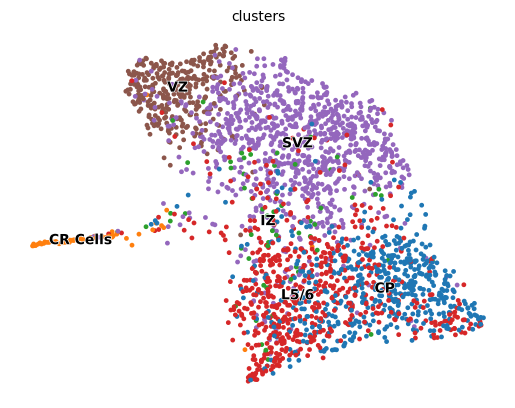

In [4]:
scv.pl.scatter(adata)

## Step 3: Train a VAE Model
### 3.1 Build a spatial graph
This can be achieved by directly calling `build_spatial_graph`. <br>
There are three different methods for graph construction:
1. K-nearest-neighbor graph: You can set `method='KNN'` and `n_neighbors` to be the number of neighbors.
2. Delaunay triangulation: You can set `method='Delaunay'`.
3. Epsilon ball graph: You can set `method='BallTree'` and `radius` to be the radius of the ball in space.

In [5]:
tpv.build_spatial_graph(adata,
                        spatial_key='X_spatial',
                        graph_key='spatial_graph',
                        method='Delaunay')

**Alternative: load a pre-computed graph** <br>
We can also precompute a spatial graph using tools outside the package. Here, we use a spatial graph from CytoSignal, which applies Delaunay triangulation with pruning to obtain a spatial graph.

In [6]:
from scipy.io import mmread
graph = mmread(f'{data_path}/DT_nn_graph.mtx').tocsr().T
adata.obsp['spatial_graph'] = graph

Visualize the spatial graph

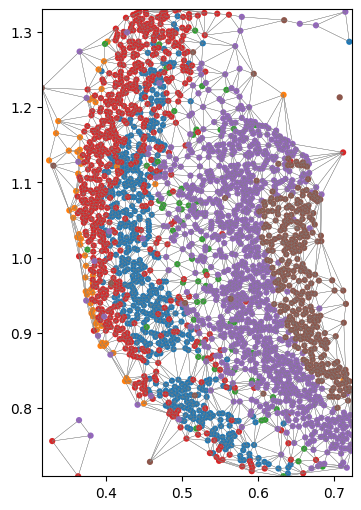

In [7]:
tpv.plotting.plot_spatial_graph(adata, graph_key='spatial_graph', basis='spatial', width=4)

### 3.2 Model Training
Here, we first train a TopoVelo with graph attention (GAT).

In [8]:
# Set paths to save figures and model parameters
adata_path = '/scratch/welchjd_root/welchjd/shared_data/gyichen/data/topovelo/slide-seq-brain-cortex'
figure_path = f'{main_figure_path}/gat'
model_path = f'{main_model_path}/gat'

#### 3.2.1 Create a VAE object
`topovelo.VAE` is the class for constructing a VAE object. <br>
Mandatory arguments include
1. `adata`: AnnData object.
2. `tmax`: Maximum time (20 as suggested in scVelo). This is just for constructing a time prior distribution.
3. `dim_z`: Dimension of the latent cell embedding.
4. `hidden_size`: Number of hidden units in neural networks. The argument is a tuple with 3 entries (N0, N1, N2). N0 is for the encoder, while N2 is for the decoder. N1 is only effective if the decoder is an MLP instead of a GNN. The default hidden size is N0=500, N1=250, N2=500. Here, we use a much smaller network because the input has only 400 dimensions.

Other important hyperparameters user need to consider include
1. graph_decoder: If set to False, an MLP will be used for the decoder.
2. attention: If set to False, spectral graph convolution

---
General suggestions for setting model hyperparameters
1. Properly choose the neural network size. A rule of thumb is to make `hidden_size` proportional to the **number of genes**. In this example, we only have 200 genes, so we use a small neural network with 50 hidden units.


2. If your dataset contains many different cell types or rich cellular information, you can increase the model capacity by increasing the latent dimension `dim_z`. The value should always be less than the number of genes and is usually **below 20**.

In [9]:
vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              hidden_size=(50, 25, 50),
              device='cuda:0',
              graph_decoder=True,
              attention=True)

Estimating ODE parameters...


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/200 [00:00<?, ?it/s]

#### 3.2.2 Training
All training hyper parameters can be saved into a dictionary `config` and we can pass it to the `train` function. The mandatory input arguments of `train` include:
1. `adata`: Preprocessed AnnData object.
2. `graph`: Spatial graph adjacency matrix. Should be in scipy sparse matrix format, e.g.`scipy.sparse.csr_matrix`.
3. `spatial_key`: Key in `.obsm` representing the spatial coordinates.
4. `cluster_key`: Cell type annotation in `.obs`, set to `clusters` by default.

Any customized training hyperparameter can be included in a dictionary `config` and passed to the `train` function. Here are some key hyperparameters you need to consider change in `config`:
1. `learning_rate`: learning rate of neural network parameters. Should be in the range $[10^{-5},10^{-2}]$.


2. `learning_rate_ode`: learning rate of ODE parameters. Should be in the range $[10^{-5},10^{-2}]$ and typically greater than `learning_rate`.


3. `learning_rate_post`: learning rate of neural network parameters in the fine-tune stage (stage 2), usually the same as `learning_rate`
___
#### Notes
**There is always a trade-off between training time and the validation loss. The training time depends on the number of cells and graph density. From the developers' experience,  If you want to reduce the training time, please consider changing the following hyperparameters.**

a. `'n_refine'`: By default, the training process applies early stopping In the fine tuning stage (stage 2). Stage 2 consists of several rounds of model update using minibatch gradient descent. You can set `n_refine` to change the maximum number of refinement iterations. It's set to **20** by default.

b. Each round automatically stops when the validation loss does not increase by a $\epsilon$ for $k$ epochs. Sometimes you may suffer from a long training time with the default $\epsilon$ and $k$ values. You can choose to increase $\epsilon$ by setting `'early_stop_thred'` or decrease `k` by setting `'early_stop'`. By default, `early_stop_thred = number_of_genes * 1e-4` and `k=5`.

c. `'batch_size'`: number of samples in each training iteration. The batch size is **128** by default. Decrease the value usually increases convergence time, which is roughly equal to the training time, but can lead to worse performance. On the other hand, a large batch size can potentially cause out-of-memory error, but might result in better performance.

c. `'n_epochs'`: maximum total number of training epochs in stage 1. Set to 1000 by default.

d. `'n_epochs_post'`: maximum total number of training epochs in **each round** of stage 2 (fine tuning). Set to 500 by default.

In [10]:
config = {
    'learning_rate': 2e-4,
    'learning_rate_ode': 5e-3,
    'learning_rate_post': 2e-4
}
vae.train(adata,
          adata.obsp['spatial_graph'],
          'X_spatial',
          config=config,
          figure_path=figure_path)


*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
--------------------------- Train a TopoVelo ---------------------------
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 144.       *********
Summary: 
Train ELBO = 340.343
Test ELBO = 334.700
Total Time =   0 h :  0 m : 42 s

*********                      Stage  2                       *********


  0%|          | 0/2525 [00:00<?, ?it/s]

Stage 2: Early Stop Triggered at round 6.
Final: Train ELBO = 511.562,	Test ELBO = 512.791
*********              Finished. Total Time =   0 h :  1 m :  8 s             *********


#### 3.2.3 Save results
Use `save_model` to save all model parameters as `.pt` file to `model_path`. <br>
Use `save_anndata` to write all biological quantities to the AnnData and then save it as a `.h5ad` file.

In [11]:
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'gat', adata_path, file_name="adata_out.h5ad")